After comparing Keeling's Matlab code and output, and using multiple print statements throughout my code, I am still not sure why the size of the nearest infected farm is not significant. I found a couple of bugs, but they did not change the results. I also remembered that the reason I had previously decided not to use Keeling's kernel and use a Cauchy kernel was because Keeling's kernel makes the disease progress very slowly. So I have used the Cauchy kernel in the code below. The changes that I have made result in output that is consistent with Keeling's code, however I have noticed that in this new version the number of new infected is dramatically lower than it used to be.

In [6]:
import numpy as np
from random import randint
Size = 20
N = 75 
np.random.seed(53080)
x = Size*np.random.rand(N)
np.random.seed(23003)
y = Size*np.random.rand(N)  
#np.random.seed(10)
#Cows = np.array([randint(25,250) for p in range(N)])
Cows = np.array([randint(25,51) for p in range(15)]+[randint(51,76) for p in range(30)]+[randint(76,95) for p in range(20)]+[randint(95,250) for p in range(10)])
#np.random.seed(11)
#Sheep = np.array([randint(25,250) for p in range(N)])
Sheep = np.array([randint(25,51) for p in range(15)]+[randint(51,76) for p in range(30)]+[randint(76,95) for p in range(20)]+[randint(95,250) for p in range(10)])



In [7]:
#Calculates which grid square a particular location is in (turn a 2-d coordinate into a scalar)
def WhichGrid(x,y,XRange,YRange,XNum,YNum):
    #Essentially: floor(Unif[0,1)griddim)griddim+floor(Unif[0,1)griddim)+1
    #Returns a number from 1 to griddim^2
    return(np.floor(x*(XNum/XRange))*YNum+np.floor(y*(YNum/YRange))+1)

In [8]:
def Kernel(dist_squared):
    dist_squared = np.asarray(dist_squared)
    is_scalar = False if dist_squared.ndim > 0 else True
    dist_squared.shape = (1,)*(1-dist_squared.ndim) + dist_squared.shape
    K = 1 / (pi * (1 + dist_squared**2))
    K[(dist_squared < 0.0138)] = 0.3093
    K[(dist_squared > 60*60)] = 0
    return(K if not is_scalar else K[0])

In [9]:
from math import pi
def Iterate(Status, x, y, Suscept, Transmiss, grid, first_in_grid, last_in_grid, Num, MaxRate):
    Event = 0*Status
    INF = np.where(Status>5)[0]
    NI = INF.size # Note reported farms still infectious
    IGrids = grid[INF]-1
        
    for ii in range(NI):
        INFi = INF[ii]
        trans = np.multiply(-Transmiss[INFi],Num) #transmissibility of infected farm to all other grid squares 
        maxr = MaxRate[IGrids[ii],:] #max number of animals to be infected in infected grid square
        # Elementwise multiplication
        rate = np.multiply(trans, maxr) #max number of animals to be infected in each grid square based on infected grid square
        MaxProb = 1 - np.exp(rate) #Max probability that infected farm infected noninfected farm
        rng = np.random.rand(len(MaxProb))
        m = np.where((MaxProb - rng)>0)[0]  #these grid squares need further consideration
        for n in range(len(m)):
            s = 1
            M = m[n]
            PAB = 1 - np.exp(-Transmiss[INFi]*MaxRate[IGrids[ii],M]) #Max probability that infected farm infects noninfected farms under consideration
            if (PAB == 1):
                # Calculate the infection probability for each farm in the susceptible grid
                leng = last_in_grid[M]-first_in_grid[M]+1
                R = np.random.rand(leng)
                for j in range(leng):
                    ind1 = first_in_grid[M]+j-1
                    Q = 1 - np.exp(-Transmiss[INFi]*Suscept[ind1]*Kernel((x[INFi]-x[ind1])**2+(y[INFi]-y[ind1])**2))
                    if ((R[j] < Q) & (Status[ind1] == 0)):
                        Event[ind1] = 1
            else:
                R = np.random.rand(Num[M])
                # Loop through all susceptible farms in the grids where an infection event occurred.  
                for j in range(Num[M]):
                    P = 1 - s*(1 - PAB)**(Num[M] - j)
                    if (R[j] < (PAB / P)):
                        s = 0
                        ind1=first_in_grid[M]+j-1
                        Q=1-np.exp(-Transmiss[INFi]*Suscept[ind1]*Kernel((x[INFi]-x[ind1])**2+(y[INFi]-y[ind1])**2))
                        if ((R[j]< Q/P) & (Status[ind1] == 0)):
                            Event[ind1] = 1
    # Evolve the infection process of those farms which have been exposed and already infectious ones.  
    Status[Status > 0] += 1
    Status = Status + Event
    #m=np.where(Status==13); # Initiate Ring Culling Around Reported Farm
    #for i in range(len(m)):
    #    Status[m[i]]=-1;
    return {'Status':Status,'NI':NI}

In [10]:
def Outbreaks(Size,N,Y0,farms,end,end2,x,y,Cows,Sheep,Maxtime=1000):
    #This is an attempt of converting the Matlab Program 7.6 Code into Python
    import numpy as np
    import pandas as pd
    from math import pi
    
    Status = np.array([0]*N)    #Initial Status of each farm
    init_ind = np.random.randint(0,N)
    for i in range(Y0):
        Status[init_ind] = 6 #one farm is initially infected 

    #Cows are 10.5 times more susceptible to disease than sheep
    Suscept = Sheep+10.5*Cows
    Transmiss = 5.1e-7*Sheep + 7.7e-7*Cows 

    #Set up the grid
    grid = WhichGrid(x,y,Size,Size,10.0,10.0)
    tmp = sorted(grid) #Sort grid values
    #i = np.argsort(grid) #get indexed values after sort
    i = [i[0] for i in sorted(enumerate(grid), key=lambda x:x[1])]
    x = x[i]
    y = y[i]
    Status = Status[i]
    grid = grid[i]
    Transmiss = Transmiss[i]
    Suscept = Suscept[i]
    Cows = Cows[i]
    Sheep = Sheep[i]
    Xgrid = []
    Ygrid = []
    Num = []
    first_in_grid = []
    last_in_grid = []
    Max_Sus_grid = []
    index_inf = np.where(Status==6)[0].astype(int)
    m2 = np.array(np.where(grid==1))
    
    for i in range(1,int(max(grid))+1):
        #turn the grid square number into an x-coordinate and y-coordinate (should not exceed XNum)
        Xgrid.append(np.floor((i-1)/10))
        Ygrid.append((i-1)%10)
        m = np.array(np.where(grid==i))
        Num.append(m.shape[1])
    
        if Num[i-1] > 0:
            first_in_grid.append(m.min()) #Add the "+1" here so the indicies match those in the Keeling code
            last_in_grid.append(m.max())
            Max_Sus_grid.append(Suscept[m].max())
        else:
            first_in_grid.append(0)
            last_in_grid.append(-1)
            Max_Sus_grid.append(0)

    #Work out grid to maximum grid transmission probabilities
    from numpy import ndarray
    MaxRate = ndarray((max(grid),max(grid)))

    #Determine maximum number of animals to be infected in each grid square

    for i in range (1,int(max(grid))):
       for j in range(1,int(max(grid))):
           if ((i-1)==(j-1)) | (Num[i-1]==0) | (Num[j-1] == 0):
               MaxRate[i-1,j-1] = np.inf
           else:
               Dist2 = (Size*max([0,(abs(Xgrid[i-1]-Xgrid[j-1])-1)])/10)**2+(Size*max([0,(abs(Ygrid[i-1]-Ygrid[j-1])-1)])/10)**2
               MaxRate[i-1,j-1] = Max_Sus_grid[j-1]*Kernel(Dist2)

    #Susceptible, Exposed, Infectious, Reported.==> latent period is 4 days
    i=1; S=len(np.where(Status==0)); E=len(np.where(np.logical_and(Status>0, Status<=5)));I=len(np.where(np.logical_and(Status>5, Status<=9))); R=len(np.where(Status==10)); R2=len(np.where(Status>9)); CullSheep=0; CullCattle=0;
    i=i+1;  IterateFlag=1;

    
    S=[]
    E=[]
    I=[]
    R=[]
    R2=[]
    CullSheep=[]
    CullCattle=[]
    t=[]
    t.append(0)
    results = np.c_[np.array([1]*N),np.arange(1,N+1),np.array([0]*N)]
    
    while(np.logical_and(t[-1]<end, IterateFlag)):
        Status=Iterate(Status, x, y, Suscept, Transmiss, grid, first_in_grid, last_in_grid, Num, MaxRate)['Status']
        Sus=np.where(Status==0)[0]; Exp=np.where(np.logical_and(Status>0, Status<=5))[0]; Inf=np.where(Status>5)[0]; 
        S.append(len(Sus)); E.append(len(Exp)); I.append(len(Inf)); 
        t.append(t[i-2]+1);i+=1;
       
        #This is how I stop the simulation (all farms are infected)
        if t[-1]>5:
            if np.logical_or((E[-4]+I[-4]==0),I == N):
                IterateFlag=0
        from scipy.stats import itemfreq
        sim_num = np.array([i-1]*N)
        seq = np.arange(1,N+1)
        results_full = np.r_[results,np.c_[sim_num,seq,Status]]
        results = results_full
   
    #Return information regarding only farm of interest
    this = results_full[np.logical_or.reduce([results_full[:,1] == x for x in farms])]
    #Extract rows relating to timepoint of interest
    no_this = this[this[:,0]==end]
    #turn status to an indicator
    Status_ind = (no_this[:,2]>5).astype(int)
    #Calculate distance to index farm - first infected is first in list of coords
    coords = list(zip(x,y))
    index = np.array((coords[index_inf][0],coords[index_inf][1]))
    dist = []
    for j in range(0,N):
        b = np.array((coords[j][0],coords[j][1]))
        dist.append(np.linalg.norm(b-index))
    to_return = np.c_[no_this[:,1],Status_ind,dist,Cows,Sheep,x,y]
    
    from scipy import spatial
    #Extract the infected farms
    inf_farms = to_return[to_return[:,1]==1]
    coords = list(zip(x,y))
    #Create list of coordinates infected farms
    inf_farm_coords = list(zip(inf_farms[:,5],inf_farms[:,6]))
    list_of_inf_coords = [list(elem) for elem in inf_farm_coords]
    #Create list of coordinates of all farms
    list_of_coords = [list(elem) for elem in coords]
    #Calculate Euclidean distance from each farm to all infected farms- each row in matrix represents
        #distance of one farm to each infected farm
    dist_to_inf = spatial.distance_matrix(list_of_coords,list_of_inf_coords)
    #Find distance to closest infected farm
    def minval(array):
        #return(np.min(array[np.nonzero(array)]))
        return(np.min(array))
    closest_infected = np.apply_along_axis(minval,1,dist_to_inf)
    average_infected = np.apply_along_axis(np.mean,1,dist_to_inf)
    to_return = np.c_[to_return,closest_infected,average_infected]
    
    #Create list of number of Cows and number of sheep for infected farms
    inf_farm_cows = list(inf_farms[:,3])
    inf_farm_sheep = list(inf_farms[:,4])
    #Create a function that extracts farm size based on closest infected farm
    def where_minval(array):
        #return(np.argmin(array[np.nonzero(array)]))
        return(np.argmin(array))
    closest_infected_size_ind = np.apply_along_axis(where_minval,1,dist_to_inf)
    closest_infected_cows = [inf_farm_cows[i] for i in closest_infected_size_ind]
    closest_infected_sheep = [inf_farm_sheep[i] for i in closest_infected_size_ind]

    #Returns array: farmID, Status_ind, dist_to_index, num_Cows,num_Sheep,x,y,,disttoclosestinf,avgdisttoinf,#cowsinclosestiffarm,#sheepinclosestinffarm
    to_return = np.c_[to_return,closest_infected_cows,closest_infected_sheep]
    
    #Now run the outbreak for the additional end - end2 steps
    while(np.logical_and(t[-1]<end2, IterateFlag)):
        Status=Iterate(Status, x, y, Suscept, Transmiss, grid, first_in_grid, last_in_grid, Num, MaxRate)['Status']
        Sus=np.where(Status==0)[0]; Exp=np.where(np.logical_and(Status>0, Status<=5))[0]; Inf=np.where(Status>5)[0]; 
    
        S.append(len(Sus)); E.append(len(Exp)); I.append(len(Inf)); 
        t.append(t[i-2]+1);i+=1;
    
    #Return only the data where a farm was not infected by the "end" day
    not_inf = to_return[to_return[:,1]==0]
    #append the status of these farms after the additional end2 - end days
    newstatus = [Status[i] for i in not_inf[:,0]-1]
    newstatus_ind = np.array([i>5 for i in newstatus]).astype(int)
    final = np.c_[not_inf,newstatus_ind]
    return(final)
    
test = Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),end=10,end2=50,x=x,y=y,Cows=Cows,Sheep=Sheep)

/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:56: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:20: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:20: DeprecationWarning: using a non-integer number instead of an integer will result i

In [11]:
test[:,11]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [12]:
import numpy as np
from random import randint
Outbreak = Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),end=10,end2=50,x=x,y=y,Cows=Cows,Sheep=Sheep)
Outbreak = np.c_[np.array([1]*Outbreak.shape[0]),Outbreak]
Num_outbreaks = 1000
for i in range(Num_outbreaks):
    #Cows = np.array([randint(25,250) for p in range(N)])
    Cows = np.array([randint(25,51) for p in range(15)]+[randint(51,76) for p in range(30)]+[randint(76,95) for p in range(20)]+[randint(95,250) for p in range(10)])
    #Sheep = np.array([randint(25,250) for p in range(N)])
    Sheep = np.array([randint(25,51) for p in range(15)]+[randint(51,76) for p in range(30)]+[randint(76,95) for p in range(20)]+[randint(95,250) for p in range(10)])
    add = Outbreaks(Size=Size,N=N,Y0=1,farms = np.arange(1,N+1),end=10,end2=50,x=x,y=y,Cows=Cows,Sheep=Sheep)
    add = np.c_[np.array([i+2]*add.shape[0]),add]
    new_Outbreak = np.r_[Outbreak,add]
    Outbreak = new_Outbreak 
    print(i,np.sum(add[:,12]==1))

/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:56: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:11: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


0 3
1 0
2 0
3 0
4 0
5 0
6 0
7 1
8 0
9 0
10 1
11 1
12 0
13 1
14 1
15 0
16 1
17 1
18 0
19 0
20 1
21 0
22 2
23 0
24 0
25 1
26 0
27 1
28 1
29 0
30 0
31 0
32 0
33 3
34 3
35 0
36 0
37 0
38 0
39 0
40 2
41 2
42 0
43 0
44 0
45 0
46 0
47 0
48 0
49 0
50 0
51 1
52 0
53 0
54 1
55 2
56 3
57 1
58 2
59 0
60 0
61 0
62 2
63 0
64 2
65 0
66 1
67 0
68 1
69 2
70 0
71 0
72 0
73 0
74 1
75 0
76 1
77 1
78 0
79 0
80 0
81 0
82 0
83 0
84 0
85 2
86 0
87 0
88 0
89 0
90 0
91 0
92 0
93 3
94 0
95 0
96 0
97 1
98 1
99 1
100 0
101 0
102 0
103 0
104 1
105 0
106 0
107 0
108 0
109 1
110 2
111 0
112 1
113 1
114 0
115 2
116 0
117 0
118 1
119 0
120 0
121 0
122 0
123 0
124 1
125 1
126 2
127 1
128 0
129 1
130 0
131 0
132 0
133 0
134 0
135 0
136 0
137 0
138 2
139 1
140 2
141 1
142 1
143 0
144 0
145 1
146 0
147 0
148 2
149 0
150 1
151 0
152 0
153 0
154 1
155 0
156 2
157 1
158 2
159 1
160 0
161 0
162 0
163 0
164 0
165 0
166 0
167 0
168 0
169 0
170 3
171 3
172 0
173 0
174 0
175 0
176 0
177 0
178 1
179 0
180 1
181 1
182 1
183 0
184 0


/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:20: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:108: DeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
/Users/sandyalakkur/anaconda/envs/py3k/lib/python3.4/site-packages/IPython/kernel/__main__.py:160: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [13]:
import pandas as pd
df = pd.DataFrame(Outbreak)
df.columns = ['run','farmID','Status','DistToIndex','NumCows','NumSheep','x-coord','y-coord','DistToNearestInfected','AvgDistToInfected','CowsNearestInfected','SheepNearestInfected','Status2']
long_random_everything_andind_anddist2 = df
long_random_everything_andind_anddist2

,run,farmID,Status,DistToIndex,NumCows,NumSheep,x-coord,y-coord,DistToNearestInfected,AvgDistToInfected,CowsNearestInfected,SheepNearestInfected,Status2
0,1,1,0,20.757396,190,206,0.428463,1.864803,20.757396,20.757396,222,200,0
1,1,2,0,18.509917,91,87,0.391203,6.562081,18.509917,18.509917,222,200,0
2,1,3,0,17.417512,61,68,0.414427,10.122575,17.417512,17.417512,222,200,0
3,1,4,0,16.556293,43,31,0.996829,15.573354,16.556293,16.556293,222,200,0
4,1,5,0,16.035718,66,66,1.869069,17.528015,16.035718,16.035718,222,200,0
5,1,6,0,19.040339,27,36,2.842180,1.531988,19.040339,19.040339,222,200,0
6,1,7,0,19.803052,75,65,2.762186,0.461724,19.803052,19.803052,222,200,0
7,1,8,0,16.900562,65,69,2.449791,5.959629,16.900562,16.900562,222,200,0
8,1,9,0,16.450377,30,44,2.138491,7.732310,16.450377,16.450377,222,200,0
9,1,10,0,14.890135,69,64,2.561501,13.778480,14.890135,14.890135,222,200,0


In [14]:
np.sum(long_random_everything_andind_anddist2['Status2']==1)

491

In [15]:
dist_diff = (long_random_everything_andind_anddist2['DistToNearestInfected'] - long_random_everything_andind_anddist2['DistToNearestInfected'].mean())/5
closest_cow_diff = (long_random_everything_andind_anddist2['CowsNearestInfected'] - long_random_everything_andind_anddist2['CowsNearestInfected'].mean())/20
closest_sheep_diff = (long_random_everything_andind_anddist2['SheepNearestInfected'] - long_random_everything_andind_anddist2['SheepNearestInfected'].mean())/20
status = long_random_everything_andind_anddist2['Status2']
from pymc import Normal, Binomial, Gamma, Lambda, invlogit, MCMC, Matplot, Bernoulli, MAP, AdaptiveMetropolis
#N = df.shape[0]

def pooled_model():
    
    # Common slope & intercept prior
    intercept = Normal('intercept', mu=0., tau=0.001, value = 0) 
    
    first_coef = Normal('first_coef', mu=0., tau=0.001, value = 0)
    
    size_coef = Normal ('size_coef', mu=0., tau= 0.001, value=[0]*2)
    
    #likelihood model
    prob = Lambda('prob', lambda intercept=intercept,first_coef=first_coef, size_coef= size_coef: 
                  invlogit(intercept + first_coef*dist_diff + size_coef[0]*closest_cow_diff + 
                           size_coef[1]*closest_sheep_diff))
    
    y = Bernoulli('y', p=prob, value=status, observed=True)
    
    return locals()

In [16]:
chains = 2
iterations = 10000
burn = 4000
M_pooled = MCMC(pooled_model())
M_map = MAP(pooled_model())
M_pooled = MCMC(M_map)
#M_pooled.use_step_method(AdaptiveMetropolis, M_pooled.b)
for i in range(chains):
    M_pooled.sample(iterations, burn)

 [-----------------100%-----------------] 10000 of 10000 complete in 128.1 sec

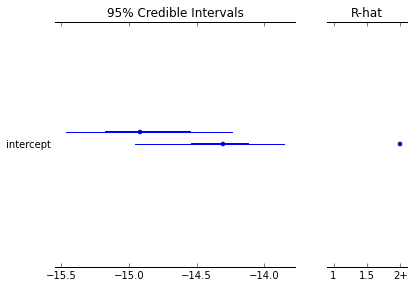

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
Matplot.summary_plot(M_pooled.intercept)

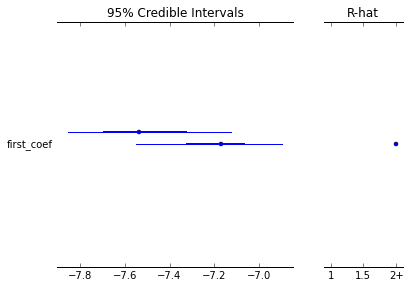

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt
Matplot.summary_plot(M_pooled.first_coef)

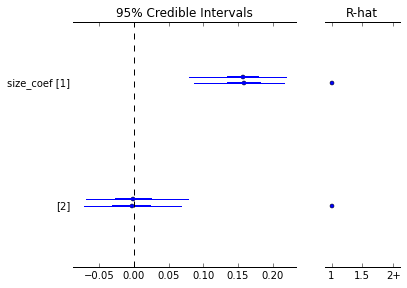

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
Matplot.summary_plot(M_pooled.size_coef)